In [0]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install arch
! pip install pyflux
import pyflux as pf

     |████████████████████████████████| 716kB 2.8MB/s 
     |████████████████████████████████| 1.3MB 2.4MB/s 
     |████████████████████████████████| 962kB 8.9MB/s 
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=4656525 sha256=2305d109b46f6e45b4464f49f9f05726184aa5bb199f5dfc87bc322a8542e59f
  Stored in directory: /root/.cache/pip/wheels/36/24/09/d18fa4f926cc90598d23ebd09fb4b0fd7b3dd1d2f506b952de
Successfully built pyflux


In [0]:
!git clone https://github.com/vmeylan/machine_learning_for_finance.git

Cloning into 'machine_learning_for_finance'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 153 (delta 24), reused 29 (delta 11), pack-reused 95
Receiving objects: 100% (153/153), 87.20 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Checking out files: 100% (26/26), done.


### Data Analysis

#### ZRX

In [0]:
data = pd.read_csv('machine_learning_for_finance/data/preprocessed_data/zrx.csv').drop(['Unnamed: 0', '_INTERCEPT', '_REALIZED_VOL', '_VOL_PROXY', '_NEGATIVE_RETURNS', '_BTC_REALIZED_VOL', '_BTC_VOL_PROXY','BTC_low', 'BTC_high', 'high', 'low', '_BTC_NEGATIVE_RETURNS', 'time'], axis=1)

In [0]:
data.head()

,BTC_close,BTC_volume,_BTC_RETURNS,_TO_EXCHANGE_TRANSACTIONS,_FROM_EXCHANGE_TRANSACTIONS,_ONCHAIN_TRANSACTIONS,_ONCHAIN_VOLUME,close,volume,_RETURNS
0,4330.00,19839.87,-0.008699,620,407,1027,1.004977e+25,0.000081,1062.62,-0.034045
1,4309.83,1052374.12,-0.004669,404,501,905,1.128882e+25,0.000082,482.42,0.014438
2,4377.86,1816507.32,0.015662,268,302,570,4.430195e+24,0.000079,757.05,-0.039269
3,4562.12,2603649.16,0.041227,647,424,1071,9.318923e+24,0.000080,763.06,0.007050
4,4566.93,2323879.98,0.001054,494,401,895,7.731110e+24,0.000074,617.25,-0.079614


In [0]:
data.columns

Index(['BTC_close', 'BTC_volume', '_BTC_RETURNS', '_TO_EXCHANGE_TRANSACTIONS',
       '_FROM_EXCHANGE_TRANSACTIONS', '_ONCHAIN_TRANSACTIONS',
       '_ONCHAIN_VOLUME', 'close', 'volume', '_RETURNS'],
      dtype='object')

In [0]:
data.loc[:,'VOL'] = (data._RETURNS**2).ewm(halflife=10).mean()
data.loc[:,'_FROM_EXCHANGE_EWMA'] = (data._FROM_EXCHANGE_TRANSACTIONS**2).ewm(halflife=10).mean()

([<matplotlib.axis.XTick at 0x7fa4e61dcac8>,
 <a list of 5 Text xticklabel objects>)

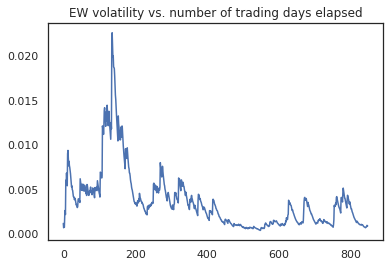

In [0]:
plt.plot((data._RETURNS**2).ewm(halflife=10).mean())
plt.title('EW volatility vs. number of trading days elapsed')
plt.xticks(ticks = [0,200,400,600,800])

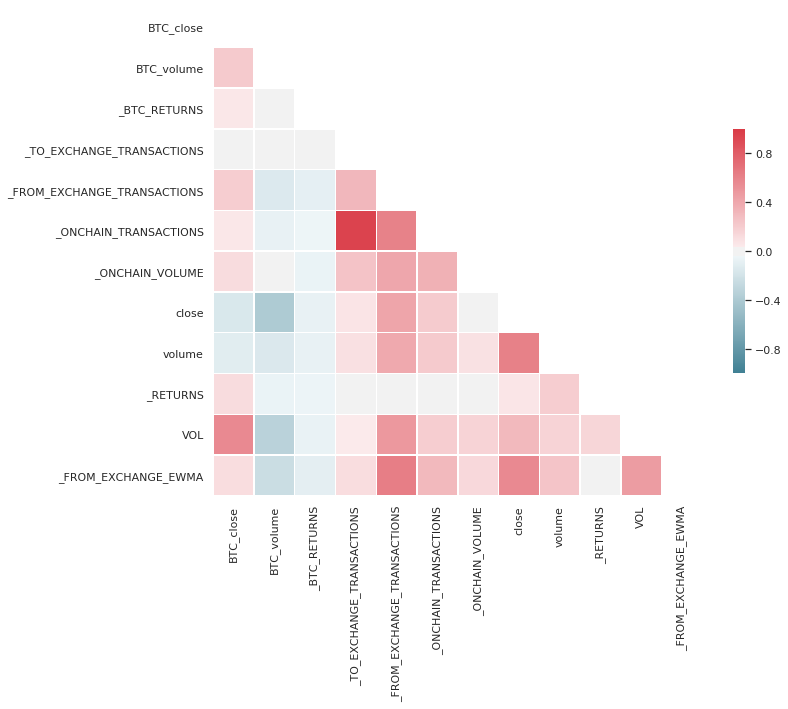

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
pass

In [0]:
data = data.loc[~data.isna().any(axis=1)] # drop NaN rows

In [0]:
X = data.drop('VOL', axis=1)
y = data.VOL

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=True)

### *) Statistical Significance

In [0]:
# Computation of the F scores for each feature to see which features are statistically significant

from sklearn.feature_selection import f_regression

p_val = f_regression(X, y)[1]
p_val_table = pd.DataFrame({'p_val':p_val,
              'column_name': data.drop(['_RETURNS'], axis=1).columns}).sort_values('p_val')
display('Statistical significance to predict returns^2')
print(p_val_table.to_latex(index=False))

'Statistical significance to predict returns^2'

\begin{tabular}{rl}
\toprule
        p\_val &                  column\_name \\
\midrule
 1.539298e-73 &                    BTC\_close \\
 1.530532e-51 &  \_FROM\_EXCHANGE\_TRANSACTIONS \\
 1.327524e-46 &          \_FROM\_EXCHANGE\_EWMA \\
 4.778608e-22 &                   BTC\_volume \\
 1.199151e-20 &                        close \\
 2.429822e-09 &        \_ONCHAIN\_TRANSACTIONS \\
 5.853581e-07 &                       volume \\
 6.199877e-07 &              \_ONCHAIN\_VOLUME \\
 6.077035e-06 &                          VOL \\
 5.986487e-02 &                 \_BTC\_RETURNS \\
 2.042026e-01 &    \_TO\_EXCHANGE\_TRANSACTIONS \\
\bottomrule
\end{tabular}



In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=True)

In [0]:
cv.best_params_

{'max_depth': 1, 'n_estimators': 10}

There are too many variables for the model to predict correctly with the amount of data (800 observations). This is called overfitting. We will fit simpler models.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

print('R2 for a Linear Regression with one variable only')
print('=================================================')
def LR_results(variable):

  X = (data.loc[:, variable].values.reshape(-1,1))

  reg = LinearRegression()


  reg.fit(X,y)
  

  return reg.score(X,y)


for variable in data.columns:
  if variable == 'VOL':
    continue
  print(' {:.2f} - {}'.format(LR_results(variable), variable))

R2 for a Linear Regression with one variable only
 0.32 - BTC_close
 0.10 - BTC_volume
 0.00 - _BTC_RETURNS
 0.00 - _TO_EXCHANGE_TRANSACTIONS
 0.24 - _FROM_EXCHANGE_TRANSACTIONS
 0.04 - _ONCHAIN_TRANSACTIONS
 0.03 - _ONCHAIN_VOLUME
 0.10 - close
 0.03 - volume
 0.02 - _RETURNS
 0.22 - _FROM_EXCHANGE_EWMA


In [0]:
df = pd.DataFrame([[0.32, 'BTC_close'],
 [0.10,'BTC_volume'],
 [0.00, '_BTC_RETURNS'],
 [0.00, '_TO_EXCHANGE_TRANSACTIONS'],
 [0.24, '_FROM_EXCHANGE_TRANSACTIONS'],
 [0.04, '_ONCHAIN_TRANSACTIONS'],
 [0.03, '_ONCHAIN_VOLUME'],
 [0.10 ,'close'],
 [0.03, 'volume']])
print(df.to_latex(index=False))

\begin{tabular}{rl}
\toprule
    0 &                            1 \\
\midrule
 0.32 &                    BTC\_close \\
 0.10 &                   BTC\_volume \\
 0.00 &                 \_BTC\_RETURNS \\
 0.00 &    \_TO\_EXCHANGE\_TRANSACTIONS \\
 0.24 &  \_FROM\_EXCHANGE\_TRANSACTIONS \\
 0.04 &        \_ONCHAIN\_TRANSACTIONS \\
 0.03 &              \_ONCHAIN\_VOLUME \\
 0.10 &                        close \\
 0.03 &                       volume \\
\bottomrule
\end{tabular}



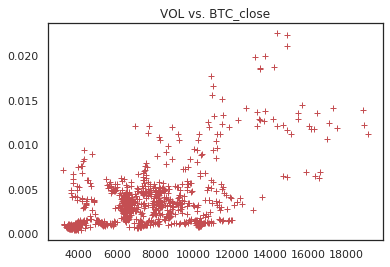

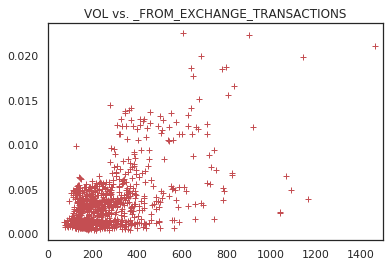

In [0]:
plt.plot(data.BTC_close, data.VOL, 'r+')
plt.title('VOL vs. BTC_close')
plt.figure()
plt.plot(data._FROM_EXCHANGE_TRANSACTIONS, data.VOL, 'r+')
plt.title('VOL vs. _FROM_EXCHANGE_TRANSACTIONS')
plt.xlim((0,1500))
pass

### *) Comparison with Volatility arima model

In [0]:
data

,BTC_close,BTC_volume,_BTC_RETURNS,_TO_EXCHANGE_TRANSACTIONS,_FROM_EXCHANGE_TRANSACTIONS,_ONCHAIN_TRANSACTIONS,_ONCHAIN_VOLUME,close,volume,_RETURNS,VOL,_FROM_EXCHANGE_EWMA
0,4330.00,1.983987e+04,-0.008699,620,407,1027,1.004977e+25,0.000081,1062.62,-0.034045,0.001159,165649.000000
1,4309.83,1.052374e+06,-0.004669,404,501,905,1.128882e+25,0.000082,482.42,0.014438,0.000667,209803.445565
2,4377.86,1.816507e+06,0.015662,268,302,570,4.430195e+24,0.000079,757.05,-0.039269,0.000979,167500.641584
3,4562.12,2.603649e+06,0.041227,647,424,1071,9.318923e+24,0.000080,763.06,0.007050,0.000722,170895.529677
4,4566.93,2.323880e+06,0.001054,494,401,895,7.731110e+24,0.000074,617.25,-0.079614,0.002006,168587.519757
...,...,...,...,...,...,...,...,...,...,...,...,...
843,6622.83,1.742293e+09,-0.040055,83,196,278,2.020436e+24,0.000027,177.03,-0.037534,0.000785,29121.543951
844,7275.25,2.525012e+09,0.093955,94,155,245,2.961992e+24,0.000028,246.55,0.025661,0.000777,28780.243649
845,7149.54,1.966181e+09,-0.017430,98,172,267,2.339215e+24,0.000026,200.71,-0.056201,0.000936,28834.068807
846,7185.21,1.345727e+09,0.004977,62,99,160,9.062641e+23,0.000027,187.05,0.024581,0.000914,27559.481127


In [0]:
data.shape, y.shape

((848, 12), (848,))

In [0]:
r = (data.VOL.shift(1) - data.VOL ) 
r[0]=0

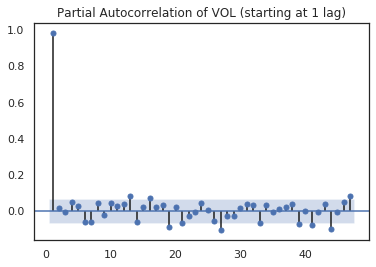

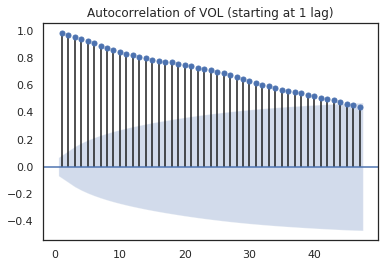

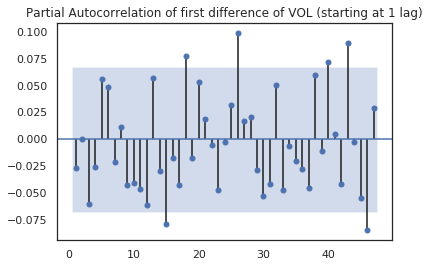

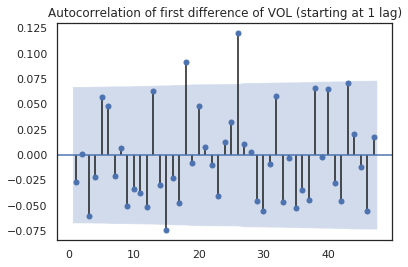

In [0]:
# As the VOL process is clearly integrated we will take the first difference

r = data.VOL
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(r, lags=list(range(1,48)))
plt.title('Partial Autocorrelation of VOL (starting at 1 lag)')
plt.show()
plot_acf(r, lags=list(range(1,48)))
plt.title('Autocorrelation of VOL (starting at 1 lag)')
plt.show()

r = (data.VOL.shift(1) - data.VOL ) 
r[0]=0
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(r, lags=list(range(1,48)))
plt.title('Partial Autocorrelation of first difference of VOL (starting at 1 lag)')
plt.show()
plot_acf(r, lags=list(range(1,48)))
plt.title('Autocorrelation of first difference of VOL (starting at 1 lag)')
plt.show()


In [0]:
# ARIMAX model with the stat significant variables.
import  copy
data_temp = copy.copy(data)
data_temp.loc[:,'_RETURNS_2'] = y**2
df = data_temp
normalized_df=(df-df.mean())/df.std()
model = pf.ARIMAX(data=normalized_df, formula='_RETURNS_2~1+BTC_close+volume',
                  ar=1,ma=0, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: _RETURNS_2                          Method: MLE                                       
Start Date: 1                                           Log Likelihood: -88.1269                          
End Date: 847                                           AIC: 186.2537                                     
Number of observations: 847                             BIC: 209.9622                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9298     0.011      84.8646  0.0      (0.9083 | 0.9513)        
Beta 1                               

In [0]:
# ARIMAX model with the most correlated variables.
import  copy
data_temp = copy.copy(data)
data_temp.loc[:,'_RETURNS_2'] = y**2
df = data_temp
normalized_df=(df-df.mean())/df.std()
model = pf.ARIMAX(data=normalized_df, formula='VOL~1+_TO_EXCHANGE_TRANSACTIONS+_FROM_EXCHANGE_TRANSACTIONS+BTC_close+volume+_BTC_RETURNS',
                  ar=1,ma=1,integ=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced VOL                     Method: MLE                                       
Start Date: 1                                           Log Likelihood: 253.2723                          
End Date: 847                                           AIC: -488.5445                                    
Number of observations: 846                             BIC: -445.8799                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.5129    0.1122     -4.5731  0.0      (-0.7328 | -0.2931)      
MA(1)                                

In [0]:
# ARIMAX model with the volume.
import  copy
data_temp = copy.copy(data)
data_temp.loc[:,'_RETURNS_2'] = y**2
df = data_temp
normalized_df=(df-df.mean())/df.std()
model = pf.ARIMAX(data=normalized_df, formula='_RETURNS_2~1+volume',
                  ar=1, ma=0, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: _RETURNS_2                          Method: MLE                                       
Start Date: 1                                           Log Likelihood: -99.9478                          
End Date: 847                                           AIC: 207.8955                                     
Number of observations: 847                             BIC: 226.8623                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9579     0.0095     101.2791 0.0      (0.9394 | 0.9765)        
Beta 1                               

### *) Random Forest 

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor()

cv = GridSearchCV(rfr, {'n_estimators': [5, 10, 20, 40, 80],
                        'max_depth':[1,2,3,4, 10]})

cv.fit(X,y**2)



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 

In [0]:
print('The best Cross validated R2 score is {:.2f}'.format(cv.best_score_))

# The random forest overfit the data.

The best Cross validated R2 score is -12.57
